In [10]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations


warnings.filterwarnings('ignore')

# Load data
ust_futures = pd.read_csv('raw_futures_prices.csv', index_col=0, parse_dates=[0]).dropna(how='any', axis=0)

# Potential pairs.
pairs = list(combinations(ust_futures.columns, 2))

# Define spreads
# TODO LATER: Pull spreads from Chi-Wai's email.

from collections import defaultdict
from more_itertools import windowed

import v2.copulas.fitting as fitting
import v2.backtest.hedging as hedging
import v2.backtest.backtester as backtester
import v2.backtest.signal_ as signal_
import v2.backtest.plotting as plotting

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def plot_signal(pairs_selected, signal_object, trading_price):
    pair = pairs_selected[0]
    sig1, sig2 = signal_object.calc_signals(single = False)
    signals = signal_object.generate_signals(sig1 = sig1[pair], sig2 = sig2[pair])
    signals = pd.DataFrame(data=signals['Signal'].values, index=trading_price.index, columns=['Signal'])

    pair_leg_1 = pair[0]
    pair_leg_2 = pair[1]
    beta = 1

    execution_delay = 1
    prepped = pd.DataFrame(
        data={
            f'Leg 1 VWAP {execution_delay}': trading_price[pair_leg_1],
            f'Leg 2 VWAP {execution_delay}': trading_price[pair_leg_2],
            f'Volume 1': int(1e7),
            f'Volume 2': int(1e7),
            f'Leg 1 VWAP Volume {execution_delay}': int(1e7),
            f'Leg 2 VWAP Volume {execution_delay}': int(1e7),
            f'Signal {execution_delay}': signals['Signal'].shift(1).fillna(0),
            'Betas': beta,
            'FFR': 0.01
        }
    )
    backtest_res = backtester.simulate_pair(prepped, K=50_000, delay_time=execution_delay)

    plotting.plot_backtested(pair, trading_price, signals, beta, sig1, sig2, backtest_res)

2018 2019 2020


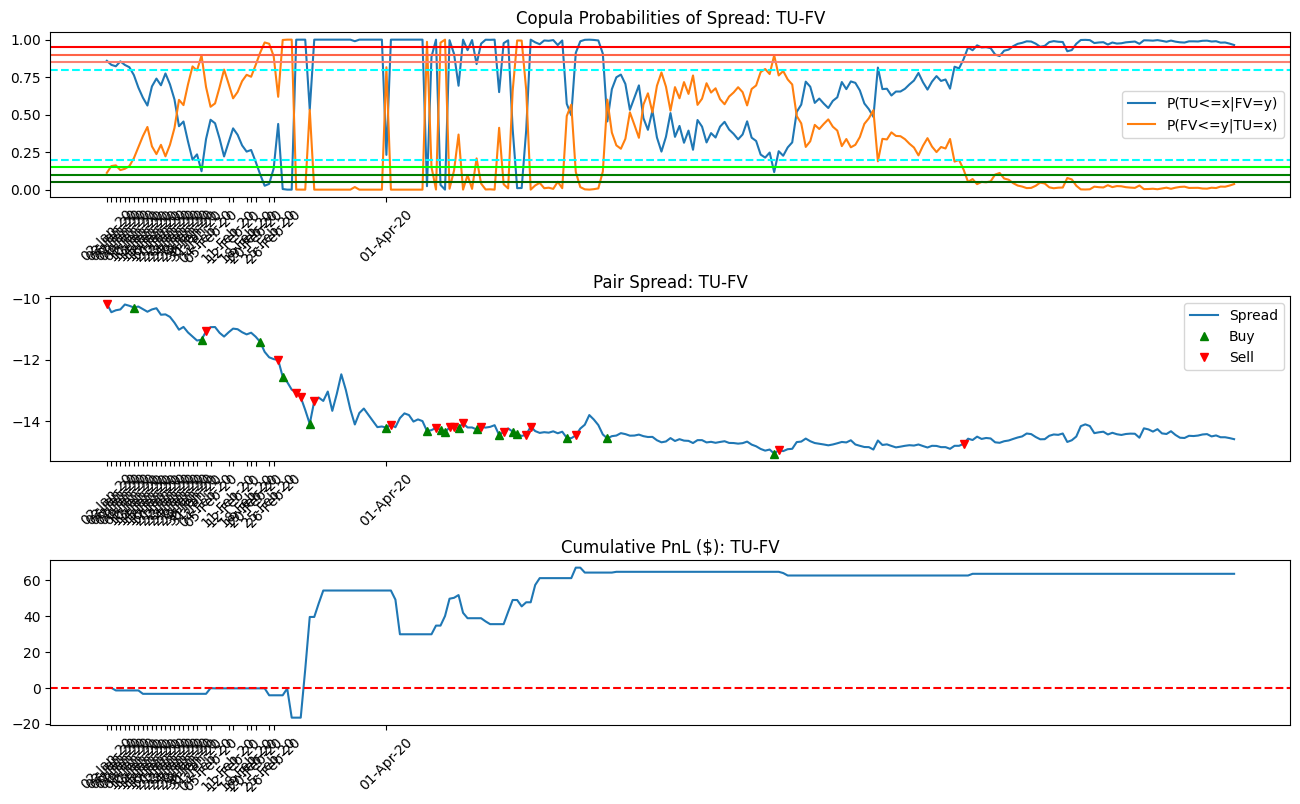

In [20]:
# PnL analysis for each pair.
yearly_copulas = defaultdict(dict)

# Make a list of years.
years = ['2018', '2019', '2020', '2021', '2022']
years_windowed = list(windowed(years, 3))

for train_start, train_end, test_end in years_windowed:
    print(train_start, train_end, test_end)
    # Fit the copulas -- index by trading year for the
    # dictionary.
    yearly_signal_obj = signal_.SignalGeneration(ust_futures, pairs, train_start, train_end, test_end, oos_end = test_end, copula_type='gumbel')
    plot_signal(pairs, yearly_signal_obj, ust_futures.loc[test_end:test_end])
    break
    

In [4]:
ust_futures

,TU,FV,TY,UXY,US,WN
date,,,,,,
2017-12-19,106.9336,115.148438,120.125000,127.140625,137.40625,164.21875
2017-12-20,106.9180,115.046875,119.875000,126.781250,136.46875,162.71875
2017-12-21,106.8945,115.015625,119.921875,126.953125,137.03125,163.90625
2017-12-22,106.8633,115.000000,119.921875,126.968750,137.06250,163.93750
2017-12-26,106.8711,115.062500,120.062500,127.171875,137.53125,164.62500
...,...,...,...,...,...,...
2023-03-22,103.4961,109.710938,115.078125,121.078125,130.96875,141.28125
2023-03-23,103.8438,110.468750,116.000000,122.015625,131.81250,141.62500
2023-03-24,103.8906,110.484375,116.125000,122.312500,132.37500,142.59375
